# Import and Setup

In [1]:
# utilities
import json
import os
import re
import pickle

# data manipulation
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# hyperparameter optimization
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# NLP tool kits
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style='whitegrid')

# machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

import tensorflow_hub as hub

# hide warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
TRAIN_PATH = r"train_for_student.json"
TEST_PATH = r"test_for_student.json"

TRAIN_PATH = os.path.join(os.path.pardir, "data", TRAIN_PATH)
TEST_PATH = os.path.join(os.path.pardir, "data", TEST_PATH)

LABEL_LIST = ['CE','ENV','BME','PE','METAL','ME','EE','CPE','OPTIC','NANO','CHE','MATENG','AGRI','EDU','IE','SAFETY','MATH','MATSCI']

# Load the Universal Sentence Encoder module
encoder_url = r'"https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/large/versions/2"'
embed = hub.load(encoder_url)

# Preprocess

In [ ]:
def clean_and_tokenize(df, word_cloud=True):
    df = df.copy()

    # combine title and abstract
    df['Text'] = df['Title'] + " " + df['Abstract']
    df.drop(columns=['Title', 'Abstract'], inplace=True)

    # remove special characters
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

    # remove publisher names
    target_text = ['published', 'licence', 'iop', 'publishing', 'ltd', 'using', 'ieee', 'association', 'elsevier', 'springer', 'wal', 'system', 'thailand', 'john' ,'wiley', 'sons', 'international', 'publications']
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in target_text]))

    # lemmitize
    # tokenize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in word_tokenize(x)  if lemmatizer.lemmatize(word).lower() not in stop_words])

    # word cloud
    if word_cloud:
        all_words = [word for tokens in df['Text'] for word in tokens]
        wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(all_words))
        plt.figure(figsize=(10, 10))
        plt.imshow(wc, interpolation='bilinear')
        plt.title('Top words after clean and tokenize')
        plt.axis('off')
        plt.show()

    return df

In [ ]:
def sentences_2_vec(df):
    df = df.copy()

    eb = embed(df['Text'].apply(lambda x: ' '.join(x)))
    df['Text'] = eb.numpy().tolist()

    return df

In [ ]:
def get_data(X, y, label, test_size=0.1, random_state=42, upsampling = True):
    X = np.array([np.array(x) for x in X['Text']])
    y = y.copy()[label]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # oversampling
    if upsampling:
        ros = RandomOverSampler(random_state=random_state)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val

In [11]:
def load_data(path, has_label=True, vectorize=True):
    # load df
    data = json.load(open(path))

    # make df
    df = pd.DataFrame(data).transpose()

    # create labels
    if has_label:
        for idx, label in enumerate(LABEL_LIST):
            df[label] = df['Classes'].apply(lambda x: 1 if label in x else 0)
        df.drop(columns=['Classes'], inplace=True)

    # create X, y
    df = clean_and_tokenize(df, not has_label)
    if has_label:
        X = df.drop(columns=LABEL_LIST)
        if vectorize:
            X = sentences_2_vec(X)
        y = df[LABEL_LIST]
        return X, y
    else:
        if vectorize:
            df = sentences_2_vec(df)
        return np.array([np.array(x) for x in df['Text']])

In [12]:
X_embedded, y = load_data(TRAIN_PATH, vectorize=True)

In [14]:
if not os.path.exists(os.path.join(os.path.curdir, "processed_data")):
    os.makedirs(os.path.join(os.path.curdir, "processed_data"))
subfolder = os.path.join(os.path.curdir, "processed_data")

pickle.dump(X_embedded, open(subfolder+"/X_embedded.pkl", "wb"))
pickle.dump(y, open(subfolder+"/y.pkl", "wb"))

# Model

In [15]:
X_train = np.array([np.array(x) for x in X_embedded['Text']])
y_train = y.to_numpy()

model = MultiOutputClassifier(VotingClassifier(estimators=[('svc', SVC(class_weight='balanced', kernel='linear')),
                                                           ('logistic', LogisticRegression(class_weight='balanced')),
                                                           ('guassiannb', GaussianNB())],
                                               voting='hard'))

model.fit(X_train, y_train)

f1_macro = np.mean(sorted(cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro'))[1:-1])
print('F1_macro:', f1_macro)

F1_macro: 0.5278550676013233


In [16]:
if not os.path.exists(os.path.join(os.path.curdir, "models")):
    os.makedirs(os.path.join(os.path.curdir, "models"))
subfolder = os.path.join(os.path.curdir, "models")

pickle.dump(model, open(subfolder+"/model.pkl", "wb"))

# Submission

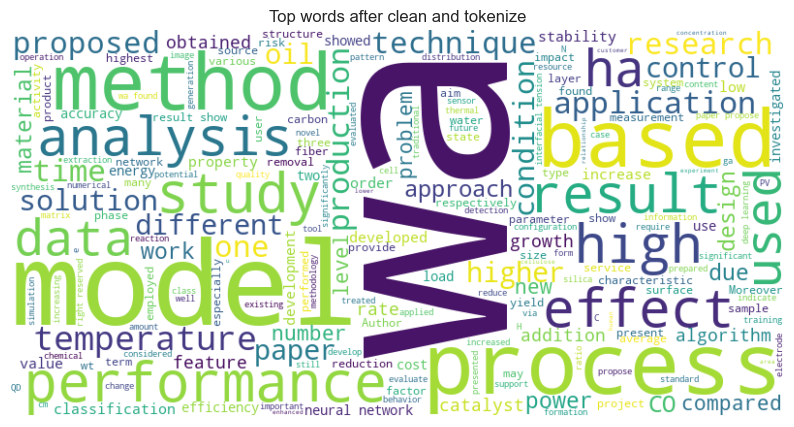

In [7]:
X_test = load_data(TEST_PATH, has_label=False)

In [8]:
submission_df = pd.DataFrame(columns= LABEL_LIST,
                             index= [f"{'0'*(3-len(str(k+1)))}{k+1}eval" for k in range(151)])

y_pred = model.predict(X_test)

submission_df.loc[:, LABEL_LIST] = y_pred
submission_df.index.name = 'id'

In [9]:
submission_df.to_csv("submission.csv")

In [10]:
!kaggle competitions submit -c 2110446-data-science-2023-02 -f submission.csv -m "test submission" 

100%|██████████████████████████████████████| 6.57k/6.57k [00:03<00:00, 1.95kB/s]
Successfully submitted to 2110446 Data Science and Data Engineering Tools